# Case study 2: Example of Thompson sampling

## Intro

I have to admit I was completely unaware of the existence of Thompson sampling (TS) algorithm before my appearance on the job interview at Atlas Copco. Having received the two case studies to choose from, I decided to learn more about the algorithm, since I already had a general idea how to approach the time series analysis in the other case study.
What started as a mere quick recon, ends here with handing in my solution.

I started with googling the wikipedia entry (https://en.wikipedia.org/wiki/Thompson_sampling) and soon found myself reading about the multi-armed bandit problem (https://en.wikipedia.org/wiki/Multi-armed_bandit), TS is often being used to solve.

Subsequently, I found a complete example of TS implementation in Python [1] (https://www.analyticsindiamag.com/thompson-sampling-explained-with-python-code/). I decided to adapt it for my case. This notebook documents my approach to tackling the TS case study, and learning and understanding the properties of TS. For the sake of curiosity, I decided to implement also two other prediction approaches to be able to compare the predictive performance.

## Assignment and settings
The provided assignment instructions were accompanied by a CSV file that contains a history of one user over a period of 2852 days. Every day, the user checks exactly one report out of five available. The task is to use the TS technique to predict what report the user will display on any particular day, based on his/her history up to that day.

Let's start with the code. Firstly, I will import some libraries that I will use later, and set up a path to the input CSV file and random generator seeds for reproducibility.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# settings
csv_path = "thomson_sampling_data.csv"
random.seed(1111)
np.random.seed(1111)

## Reading and preprocessing the input data

Here, the CSV file is imported. Two columns (_Date_ and *ReportPage*) are kept, while the third column is omitted as it contains constant value in all rows. I sort the dataframe by dates and correct a typo in the ReportPage.

Next, I create a sorted list _pages_ containing the unique report / page names. (NB: I use the terms _report_ and _page_ interchangeably.)

In [2]:
df = pd.read_csv(csv_path, sep=";", parse_dates=True, dayfirst=True, index_col=[0], usecols=[0, 1])
df.sort_index(inplace=True)
df.index.to_period(freq="D")
df.ReportPage = df.ReportPage.replace("Terriotry Insight", "Territory Insight")    # correction of a typo
print(df.head(6))
pages = sorted(set(df.ReportPage))                                                 # list of pages
print("\n", pages)

                   ReportPage
Date                         
2011-09-25      Local Insight
2011-09-26      Local Insight
2011-09-27   Customer Insight
2011-09-28    Product Insight
2011-09-29     Global Insight
2011-09-30  Territory Insight

 ['Customer Insight', 'Global Insight', 'Local Insight', 'Product Insight', 'Territory Insight']


## Report prediction using sampling based on observed frequencies
Our setting differs slightly from the multi-armed bandit problem in the sense that only one predicted value (the correct page) can bring a reward on each single day, while all the others lead to not getting the reward.

Therefore, I decided to simplify the approach found in [1] and make use of the weighted _random.choices()_ function to sample randomly the predicted value based on the known observations at the time point of prediction.

In [3]:
df = df.assign(PredictedPageFreq = "")                      # new column for storing predicted reports
freqs = [0] * len(pages)                                    # list to store frequencies of reports up to current day
matches = [0] * len(pages)                                  # list to store number of correct predictions
for i, rp in enumerate(df.ReportPage):
    if i == 0:                                              # prediction for the first day is completely random 
        p = random.choices(pages)[0]
    else:                                                   # other predictions are based on observed frequencies
        p = random.choices(pages, weights=freqs)[0]
    if p == rp: 
        matches[pages.index(p)] += 1                        # increase respective counter if predicted correctly
    freqs[pages.index(rp)] += 1                             # increase respective counter of report history
    df.iloc[i, 1] = p                                       # store predicted report name in PredictedPageFreq

### Outputs
Using this approach, I was able to correctly predict 623 reports (21.84% success  rate). You can find the summary including charts below. 

The first chart presents the true distribution of reports displayed by the user, the two charts below then show the correctly predicted reports. (Counts of correct predictions are on the left, and ratios of correctly predicted reports to the truly displayed on the right hand side.)

Correctly predicted reports: 623
Correctly predicted reports: 21.84%
Pages: Customer Insight, Global Insight, Local Insight, Product Insight, Territory Insight
Frequencies #: 720, 627, 306, 559, 640
Frequencies %: 25.25, 21.98, 10.73, 19.60, 22.44
Correct predictions #: 178, 150, 35, 108, 152
Correct predictions %: 24.72, 23.92, 11.44, 19.32, 23.75


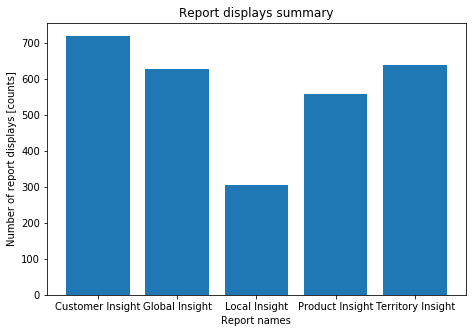

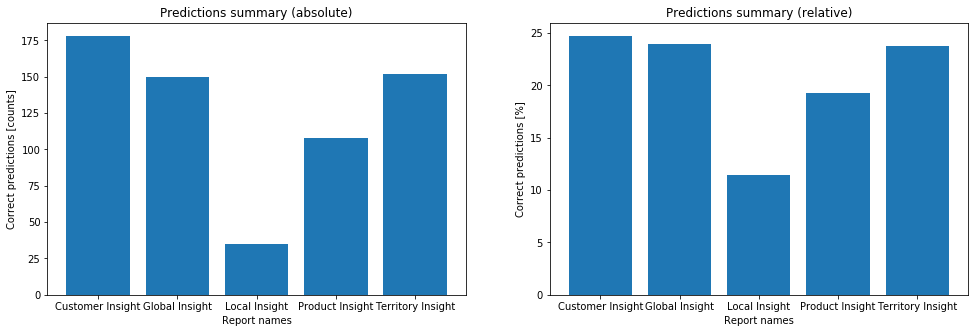

In [4]:
print("Correctly predicted reports:", sum(matches))
print("Correctly predicted reports: {:3.2f}%".format(100*sum(matches)/len(df)))
print("Pages:", ", ".join(pages))
print("Frequencies #:", ", ".join(["%.0f" % x for x in  freqs]))
print("Frequencies %:", ", ".join(["%.2f" % x for x in [100 * f / len(df) for f in freqs]]))
print("Correct predictions #:", ", ".join(["%.0f" % x for x in  matches]))
print("Correct predictions %:", ", ".join(["%.2f" % x for x in [100 * m / f  for m, f in zip(matches, freqs)]]))
plt.figure(figsize=(7.5, 5))
plt.bar(pages,freqs)
plt.title('')
plt.xlabel('Report names')
plt.ylabel('Number of report displays [counts]')
plt.title('Report displays summary')
plt.show()

plt.figure(figsize=(16.5, 5))
plt.subplot(1, 2, 1)
plt.title('Predictions summary (absolute)')
plt.bar(pages,matches)
plt.xlabel('Report names')
plt.ylabel('Correct predictions [counts]')
plt.subplot(1, 2, 2)
plt.title('Predictions summary (relative)')
plt.bar(pages,[100 * m / f  for m, f in zip(matches, freqs)])
plt.xlabel('Report names')
plt.ylabel('Correct predictions [%]')
plt.show()

## Thompson sampling using Beta distribution

After finishing the previous code, I was wondering how the original algorithm using the Beta distribution function for sampling would perform. Thus, I used the code from [1] (with only slight changes).

(Note: In this section of code, I intentionally stick to most of the original variable names from [1].)

In [5]:
df = df.assign(PredictedPageBeta = "")                                  # new column for storing predicted reports
lpages = len(pages)
rewards = [0] * lpages                                                  # list to store number of correct predictions
penalties = [0] * lpages                                                # list to store number of uncorrect predictions
total_reward = 0                                                        # counter to store total number of correct predictions
for n in range(0, len(df)):
    bandit = 0                                                          # initial chosen report
    beta_max = 0                                                        # initial value of beta distribution
    for i in range(0, lpages):                                          # going through all five pages
        beta_d = random.betavariate(rewards[i] + 1, penalties[i] + 1)   # we draw a random number from the beta distribution
        if beta_d > beta_max:                                           # if the drawn number is the highest so far...
            beta_max = beta_d
            bandit = i                                                  # ... we make the report our new prediction
    if df.iloc[n, 0] == pages[bandit]:                                  # if the prediction is correct,
        rewards[bandit] += 1                                            # increase the correct predictions counters
        total_reward += 1
    else:
        penalties[bandit] += 1                                          # else increase the incorrect counter
    df.iloc[n, 2] = pages[bandit]                                       # and finally store the report predicted for that day

### Outputs

You can see the results below, in the same structure. 

To point out, the approach with sampling using Beta distribution led to 665 correctly predicted reports (23.32% success rate), an increase of 2.5%! I was surprised by this result at first.

Correctly predicted reports: 665
Correctly predicted reports: 23.32%
Pages: Customer Insight, Global Insight, Local Insight, Product Insight, Territory Insight
Frequencies #: 720, 627, 306, 559, 640
Frequencies %: 25.25, 21.98, 10.73, 19.60, 22.44
Correct predictions #: 310, 90, 5, 9, 251
Correct predictions %: 43.06, 14.35, 1.63, 1.61, 39.22


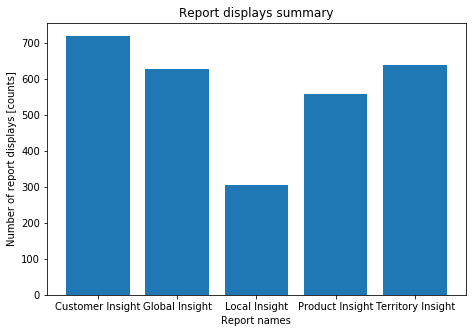

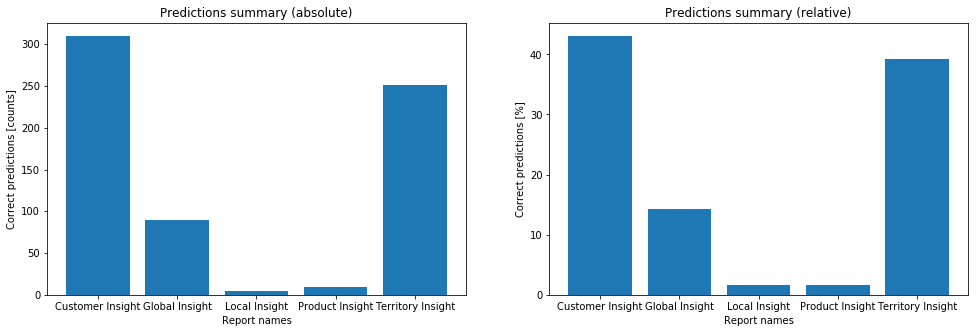

In [6]:
print("Correctly predicted reports:", total_reward)
print("Correctly predicted reports: {:3.2f}%".format(100*total_reward/len(df)))
print("Pages:", ", ".join(pages))
print("Frequencies #:", ", ".join(["%.0f" % x for x in  freqs]))
print("Frequencies %:", ", ".join(["%.2f" % x for x in [100 * f / len(df) for f in freqs]]))
print("Correct predictions #:", ", ".join(["%.0f" % x for x in  rewards]))
print("Correct predictions %:", ", ".join(["%.2f" % x for x in [100 * m / f  for m, f in zip(rewards, freqs)]]))
plt.figure(figsize=(7.5, 5))
plt.bar(pages,freqs)
plt.title('')
plt.xlabel('Report names')
plt.ylabel('Number of report displays [counts]')
plt.title('Report displays summary')
plt.show()

plt.figure(figsize=(16.5, 5))
plt.subplot(1, 2, 1)
plt.title('Predictions summary (absolute)')
plt.bar(pages,rewards)
plt.xlabel('Report names')
plt.ylabel('Correct predictions [counts]')
plt.subplot(1, 2, 2)
plt.title('Predictions summary (relative)')
plt.bar(pages,[100 * m / f  for m, f in zip(rewards, freqs)])
plt.xlabel('Report names')
plt.ylabel('Correct predictions [%]')
plt.show()

### Comparison of the two approaches

To rule out pure randomness, I re-ran both approaches ten thousand times each (not shown in the code here). I arrived at a more robust average of 602.48 and 663.87 correctly predicted reports (21.12%, resp. 23.28%) in favor of the Beta distribution.

Looking at the results, it seemed the Beta distribution approach favored more the most frequent reports in comparison with the _random.choices()_ function, whose predictions are more proportionate to the observed frequencies.

What if I based my predictions solely on the most frequently displayed report?

## Naïve prediction (most frequent report)

I decided to try a completely naïve prediction. I will always predict the report that was shown most frequently up to the current day.

In [7]:
df = df.assign(PredictedPageNaive = "")         # again a new column for storing predicted reports
matches = [0] * len(pages)
freqs = [0] * len(pages)
for i, rp in enumerate(df.ReportPage):
    if i == 0:
        p = random.choices(pages)[0]            # only the prediction for the first day is random 
    else:
        p = pages[freqs.index(max(freqs))]      # for following days, the most frequent report is chosen
        if p == rp: 
            matches[pages.index(p)] += 1        # increase respective counter if predicted correctly
    freqs[pages.index(rp)] += 1                 # increase counter of report frequencies history
    df.iloc[i, 3] = p                           # and finally store the report predicted for that day

### Outputs

The correct predictions increased again, to 719 pages (25.21%). The predictions very quickly converged to the most frequently displayed report.

Correctly predicted reports: 719
Correctly predicted reports: 25.21%
Pages: Customer Insight, Global Insight, Local Insight, Product Insight, Territory Insight
Frequencies #: 720, 627, 306, 559, 640
Frequencies %: 25.25, 21.98, 10.73, 19.60, 22.44
Correct predictions #: 713, 0, 6, 0, 0
Correct predictions %: 99.03, 0.00, 1.96, 0.00, 0.00


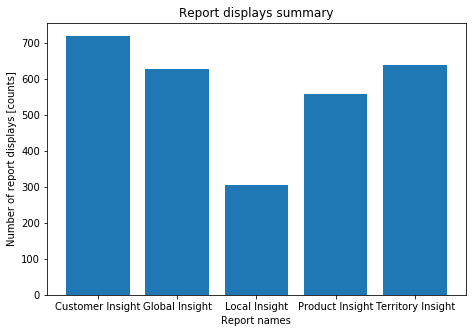

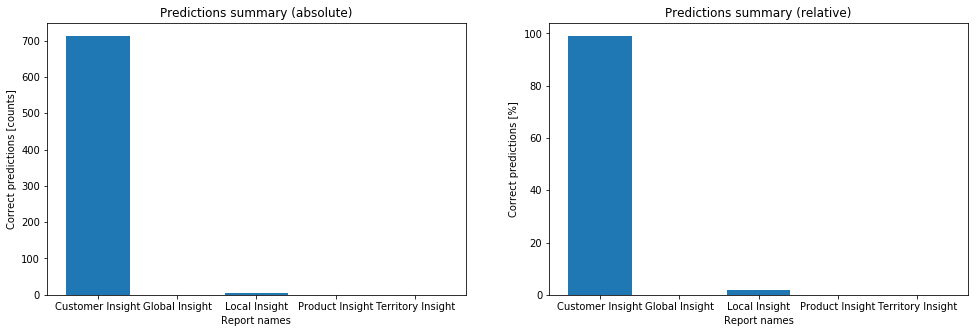

In [8]:
print("Correctly predicted reports:", sum(matches))
print("Correctly predicted reports: {:3.2f}%".format(100*sum(matches)/len(df)))
print("Pages:", ", ".join(pages))
print("Frequencies #:", ", ".join(["%.0f" % x for x in  freqs]))
print("Frequencies %:", ", ".join(["%.2f" % x for x in [100 * f / len(df) for f in freqs]]))
print("Correct predictions #:", ", ".join(["%.0f" % x for x in  matches]))
print("Correct predictions %:", ", ".join(["%.2f" % x for x in [100 * m / f  for m, f in zip(matches, freqs)]]))
plt.figure(figsize=(7.5, 5))
plt.bar(pages,freqs)
plt.title('')
plt.xlabel('Report names')
plt.ylabel('Number of report displays [counts]')
plt.title('Report displays summary')
plt.show()

plt.figure(figsize=(16.5, 5))
plt.subplot(1, 2, 1)
plt.title('Predictions summary (absolute)')
plt.bar(pages, matches)
plt.xlabel('Report names')
plt.ylabel('Correct predictions [counts]')
plt.subplot(1, 2, 2)
plt.title('Predictions summary (relative)')
plt.bar(pages,[100 * m / f  for m, f in zip(matches, freqs)])
plt.xlabel('Report names')
plt.ylabel('Correct predictions [%]')
plt.show()

## User behavior exploration

Throughout this whole exercise, I could not get rid of the idea that the whole random sampling approach for making predictions of reports displayed by a human user, might be fundamentally flawed. I would suppose that humans do not choose a report to view at random, as opposed by the randomly generated rewards of the multi-armed "bandit" slot machines.

From the very beginning, when I started exploring the provided data, I was looking for some systematic behavior. Does the user look at some reports more frequently at the beginning or at the end of a week or month? Or at some days of week? Did he/she change habits during the passing years? I could not find anything. So was the data generated by a random process?

And then I noticed a frequent appearance of the same report names every 4 days.

## AR process

If the data would be random, its autocorrelation plot would look similar to this.

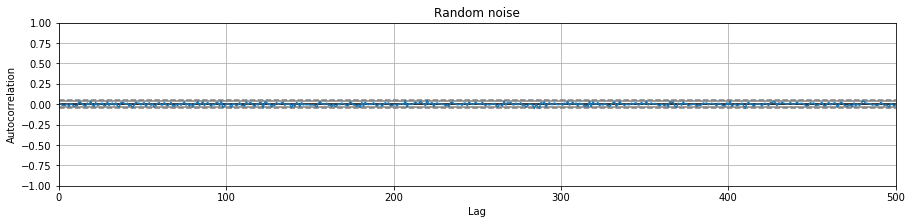

In [9]:
s = pd.Series(np.random.binomial(1, 0.25, len(df)))
plt.figure(figsize=(15, 3))
a5 = autocorrelation_plot(s)
a5.set_xlim([0, 500])
a5.set_title("Random noise")
plt.show()

How would the autocorrelation of each report's displays look like? I created a 0/1 dummy variables for each report name (equal to 1 at days, when the report was displayed, 0 otherwise).

The autocorrelation plots show there definitely is a lot of non-randomness in the data. So much basically, that the data do  most probably not reflect a human behavior...

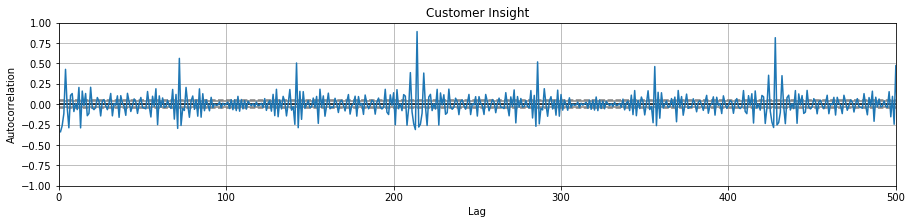

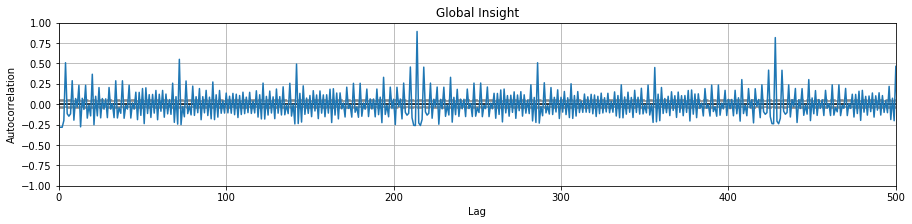

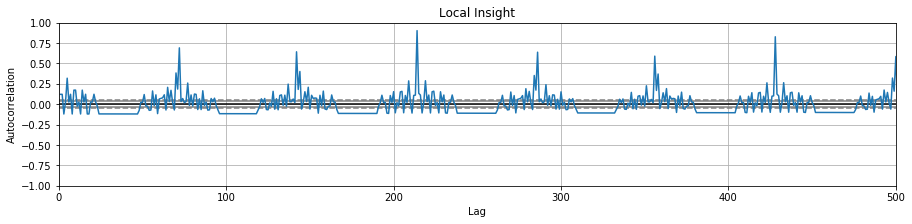

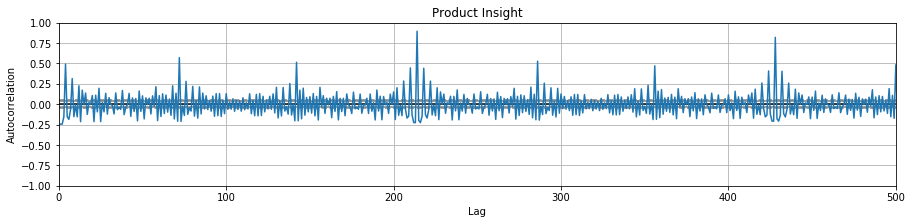

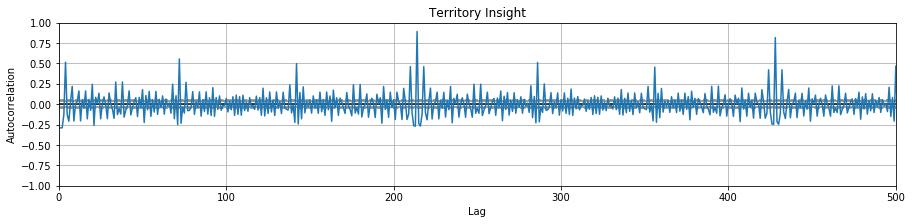

In [10]:
df = df.join(pd.get_dummies(df["ReportPage"]))

# autocorrelation - AR(4), Local insight AR(5)
plt.figure(figsize=(15, 3))
a1 = autocorrelation_plot(df["Customer Insight"])
a1.set_xlim([0, 500])
a1.set_title("Customer Insight")
plt.figure(figsize=(15, 3))
a2 = autocorrelation_plot(df["Global Insight"])
a2.set_xlim([0, 500])
a2.set_title("Global Insight")
plt.figure(figsize=(15, 3))
a3 = autocorrelation_plot(df["Local Insight"])
a3.set_xlim([0, 500])
a3.set_title("Local Insight")
plt.figure(figsize=(15, 3))
a4 = autocorrelation_plot(df["Product Insight"])
a4.set_xlim([0, 500])
a4.set_title("Product Insight")
plt.figure(figsize=(15, 3))
a5 = autocorrelation_plot(df["Territory Insight"])
a5.set_xlim([0, 500])
a5.set_title("Territory Insight")
plt.show()

As can be seen from the charts above, the series all have their highest peak at a period of 214 days, when the correlation coefficient reaches almost one. How would using this repetition improve the predictive power of the algorithm?

## Lagged predictor

To make things comparable with the previous results, I decided to implement a very simple predictor that would use the idea of autocorrelation. I reckoned that noticing the 214-days period would take some time in a real world scenario. So I was looking for a shorter-period predictor.

As can be seen from the output below, 4-day lag might work just fine, though for the *Local Indicator*, the shortest period is 5 days.

In [11]:
df[["ARCI4","ARGI4", "ARLI4", "ARPI4", "ARTI4"]] = df[["Customer Insight", \
  "Global Insight", "Local Insight", "Product Insight", "Territory Insight"]].shift(4)
df["ARLI5"] = df["Local Insight"].shift(5)
print("4-day-lag autocorrelation coefficients")
for p, ar in zip(pages, [df.ARCI4, df.ARGI4, df.ARLI4, df.ARPI4, df.ARTI4]):
    print(p + ": \t {:1.4f}".format(df[p].corr(ar, method='spearman')))
print("5-day-lag autocorrelation coefficient")
print("Local Insight: \t\t {:1.4f}".format(df["Local Insight"].corr(df.ARLI5, method='spearman')))

4-day-lag autocorrelation coefficients
Customer Insight: 	 0.4288
Global Insight: 	 0.5099
Local Insight: 	 0.0269
Product Insight: 	 0.4941
Territory Insight: 	 0.5170
5-day-lag autocorrelation coefficient
Local Insight: 		 0.3207


But could this autocorrelation be spotted quickly enough? Just using the first 60 observations, the correlation coefficients are high enough already.

In [12]:
ldf = df.iloc[0:60,:]
print("4-day-lag autocorrelation coefficients")
for p, ar in zip(pages, [ldf.ARCI4, ldf.ARGI4, ldf.ARLI4, ldf.ARPI4, ldf.ARTI4]):
    print(p + ": \t {:1.4f}".format(ldf[p].corr(ar, method='spearman')))
print("5-day-lag autocorrelation coefficient")
print("Local Insight: \t\t {:1.4f}".format(ldf["Local Insight"].corr(ldf.ARLI5, method='spearman')))

4-day-lag autocorrelation coefficients
Customer Insight: 	 0.3333
Global Insight: 	 0.4344
Local Insight: 	 0.0710
Product Insight: 	 0.3913
Territory Insight: 	 0.4640
5-day-lag autocorrelation coefficient
Local Insight: 		 0.4485


## Dummy 4-day-lag predictor
So I tried a very simple 4-day-lag predictor. The first four predictions are filled-in randomly.

In [13]:
df["AR4Predictor"] = df.ReportPage.shift(4)            # creation of new column from ReportPage with lag of 4 observations
df.iloc[0:4, 9] = random.choices(pages, k=4)           # fill-in the first 4 rows randomly
df["AR4Matches"] = df.AR4Predictor.eq(df.ReportPage)   # new column with True if prediction is correct, False otherwise
matches = [0] * len(pages)
for i, p in enumerate(pages):                          # computation of number of correct predictions per page
    matches[i] = len(df.query('AR4Matches == True and AR4Predictor == "' + p + '"'))

### Outputs
The correct predictions with this very simple predictor more than doubled, reaching 1570 pages (55.05%). The complete results are displayed below.

Correctly predicted reports: 1570
Correctly predicted reports: 55.05%
Pages: Customer Insight, Global Insight, Local Insight, Product Insight, Territory Insight
Frequencies #: 720, 627, 306, 559, 640
Frequencies %: 25.25, 21.98, 10.73, 19.60, 22.44
Correct predictions #: 412, 387, 40, 331, 400
Correct predictions %: 57.22, 61.72, 13.07, 59.21, 62.50


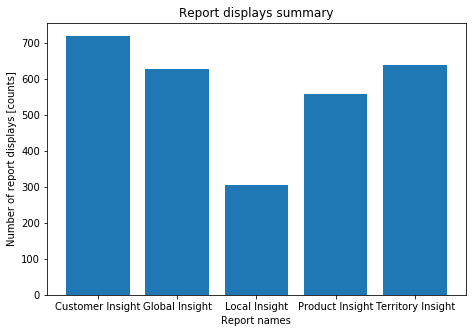

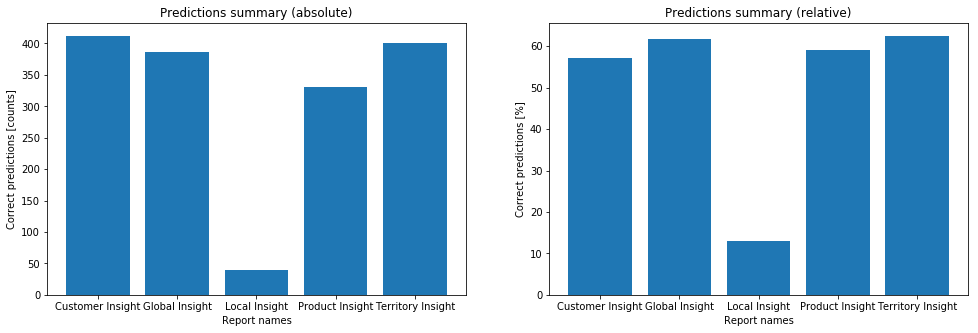

In [14]:
print("Correctly predicted reports:", sum(df.AR4Matches))
print("Correctly predicted reports: {:3.2f}%".format(100*sum(df.AR4Matches)/len(df)))
print("Pages:", ", ".join(pages))
print("Frequencies #:", ", ".join(["%.0f" % x for x in  freqs]))
print("Frequencies %:", ", ".join(["%.2f" % x for x in [100 * f / len(df) for f in freqs]]))
print("Correct predictions #:", ", ".join(["%.0f" % x for x in  matches]))
print("Correct predictions %:", ", ".join(["%.2f" % x for x in [100 * m / f  for m, f in zip(matches, freqs)]]))
plt.figure(figsize=(7.5, 5))
plt.bar(pages,freqs)
plt.title('')
plt.xlabel('Report names')
plt.ylabel('Number of report displays [counts]')
plt.title('Report displays summary')
plt.show()

plt.figure(figsize=(16.5, 5))
plt.subplot(1, 2, 1)
plt.title('Predictions summary (absolute)')
plt.bar(pages, matches)
plt.xlabel('Report names')
plt.ylabel('Correct predictions [counts]')
plt.subplot(1, 2, 2)
plt.title('Predictions summary (relative)')
plt.bar(pages,[100 * m / f  for m, f in zip(matches, freqs)])
plt.xlabel('Report names')
plt.ylabel('Correct predictions [%]')
plt.show()


## Summary 
I have presented in this Jupyter notebook, how I approached the Case study to implement Thompson sampling algorithm for report recommendation.
* I have started with an implementation using sampling proportionate to the observed frequencies.
* Then I continued with sampling drawn from Beta distribution.
* Just for comparison, I implemented also a naïve prediction using the most frequent report.
* Finally, I also briefly explored the autocorrelation properties of the input data and used a simple lagged observation as a predictor.

Along this way, I was able to increase the success rate from initial 21% up to 55%. 

Nevertheless, I am well aware that the last two predicting approaches, though performing pretty well on the provided data, would most probably not be suitable for a real world deployment. Naïve prediction would discourage exploration of reports not currently used by the users, while the autocorrelation approach in its simple form presented here works in my opinion mainly due to the properties of the artificial process generating the input data.

Thank you for your time.

If you happen to have any questions, I would be happy to discuss them on a phone call or via email.